In [1]:
import os

IMG_PATH = "_img"
CACHE_PATH = "_cache"
if not os.path.isdir(IMG_PATH): os.mkdir(IMG_PATH)
if not os.path.isdir(CACHE_PATH): os.mkdir(CACHE_PATH)

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

from tqdm import tqdm
import pickle
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy import units as u
from astropy.constants.si import L_sun

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.patches as  mpatches
import seaborn as sns

sns.set_theme(context="talk", style="ticks", palette="colorblind", color_codes=True, font_scale=1.2)

from MaStarChecks.io import load_libraries
from MaStarChecks.plotting.styles import *


PROCESSED_PATH = "../fitting/_data/processed-libraries-v3.1.2"

LABELS = ("MaStar",)
Y_COLUMNS = ["TEFF", "LOGG", "MET", "ALPHAM"]

COLOR = "#7C16A4"

def get_range(x, data=None, n=2):
    if data is None:
        xmin, xmax = x.min(), x.max()
    else:
        xmin, xmax = data[x].min(), data[x].max()
    return np.linspace(xmin, xmax, n)

In [2]:
catalogue_gaia = pd.read_csv("_data/gaia-catalogue-clean.csv", index_col="source_id")
catalogue_gaia["g"] = catalogue_gaia.phot_g_mean_mag + 5*np.log10(catalogue_gaia.parallax) - 10
catalogue_gaia["d"] = 1000 / catalogue_gaia.parallax
# catalogue_gaia

/home/mejia/.cache/pypoetry/virtualenvs/mastar-checks-RQnjUWan-py3.8/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


True 68472


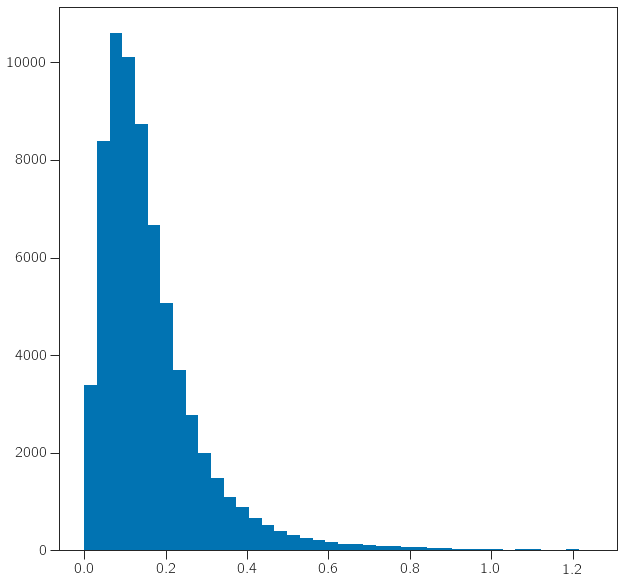

In [3]:
APOGEE_COLUMNS = ["APOGEE_ID", "RA", "DEC", "TEFF", "LOGG", "FE_H", "ALPHA_M", "TEFF_ERR", "LOGG_ERR", "FE_H_ERR", "ALPHA_M_ERR"]

apogee_fits = fits.open("_data/APOGEE/allStar-l31c.2.fits")
catalogue_aspcap = Table(apogee_fits[1].data)[APOGEE_COLUMNS].to_pandas()
catalogue_aspcap = catalogue_aspcap.mask(catalogue_aspcap==-9999)
catalogue_aspcap[["RA","DEC"]] = catalogue_aspcap[["RA","DEC"]].mask((catalogue_aspcap[["RA","DEC"]]==0).any(axis="columns"))
catalogue_aspcap = catalogue_aspcap.dropna(how="any")

catalogue_aspcap

aspcap_coords = SkyCoord(ra=catalogue_aspcap.RA.values*u.degree, dec=catalogue_aspcap.DEC.values*u.degree)
gaia_coords = SkyCoord(ra=catalogue_gaia.ra.values*u.degree, dec=catalogue_gaia.dec.values*u.degree)

idx_match, d2d, d3d = match_coordinates_sky(aspcap_coords, gaia_coords)

matches = gaia_coords[idx_match]

# should be FWHM / 2 ~ 1.25"
mask = d2d.to(u.arcsec)<=(1.25)*u.arcsec
idx_match = idx_match[mask]
print((matches.separation(aspcap_coords) == d2d).all(), mask.sum())

plt.hist(d2d.to(u.arcsec).value[mask], bins=40)

catalogue_aspcap["DIST"] = np.nan
catalogue_aspcap.loc[mask, "DIST"] = catalogue_gaia.iloc[idx_match].d.values / 1000

catalogue_aspcap.to_csv("_data/apogee-catalogue.csv", index=False)

Text(0, 0.5, '$z$ (kpc)')

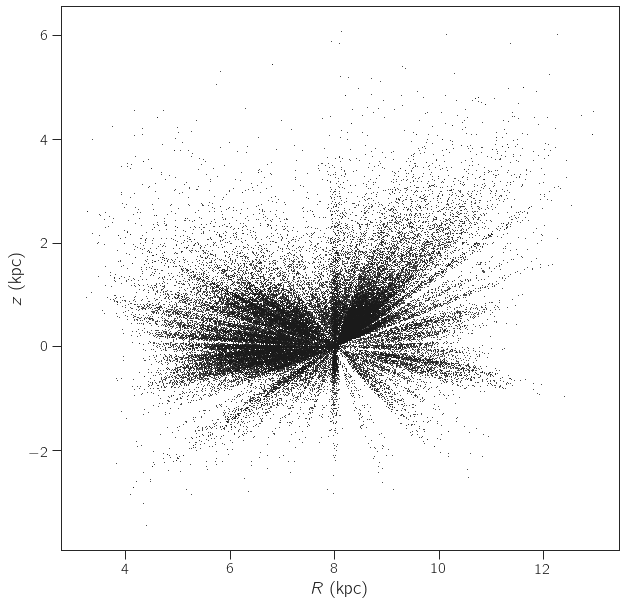

In [4]:
aspcap_coords_3d = SkyCoord(ra=catalogue_aspcap.RA.values*u.deg, dec=catalogue_aspcap.DEC.values*u.deg, distance=catalogue_aspcap.DIST.values*u.kpc)

plt.scatter(
    aspcap_coords_3d.galactic.distance.value * np.cos(aspcap_coords_3d.galactic.l.value*np.pi/180) + 8,
    aspcap_coords_3d.galactic.distance.value * np.sin(aspcap_coords_3d.galactic.b.value*np.pi/180),
    s=1, lw=0, c="k"
)
plt.xlabel("$R$ (kpc)")
plt.ylabel("$z$ (kpc)")